## Model

We will fit a simple 1D Bayesian Linear regression, with known variance.
The likelihood is given by,
$$y \sim \mathcal{N}(w_0 + w_1x, 1),$$
and the prior is,
$$w_0, w_1 \sim N(0, I).$$


In [1]:
import jax.random as jr
import jax.numpy as jnp

# generate data
data_key = jr.PRNGKey(0)
w_0 = 0.5
w_1 = -0.5

n = 10
x_key, noise_key = jr.split(data_key, 2)
x = jr.uniform(x_key, shape=(n,)) * 4 - 2 # Train the flow variationally
y = w_0 + w_1 * x + jr.normal(noise_key, shape=(n,))

In [2]:
import matplotlib.pyplot as plt

# Utility for plotting 2D contours
def plot_density(ax, density_fcn, xmin=-5, xmax=5, ymin=-5, ymax=5, n=100, levels=None, cmap="Blues"):
    xvalues = jnp.linspace(xmin, xmax, n)
    yvalues = jnp.linspace(ymin, ymax, n)

    X, Y = jnp.meshgrid(xvalues, yvalues)

    points = jnp.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])

    log_prob = density_fcn(points).reshape(n, n)

    ax.contour(log_prob, levels=levels, extent=[xmin, xmax, ymin, ymax], origin="lower", cmap=cmap)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

In [3]:
from jax.scipy.stats import norm, multivariate_normal
import jax

# Map across thetas, sum log prob over observations
_likelihood = lambda theta: norm.logpdf(y, theta[0] + x * theta[1]).sum() # for one theta
likelihood = lambda theta: jax.vmap(_likelihood)(theta)

# Prior is standard normal
prior = lambda theta: norm.logpdf(theta, 0, 1).sum(axis=1)

# Unormalized posterior
unorm_posterior = lambda theta: likelihood(theta) + prior(theta)

# True posterior for comparison
_x = jnp.vstack([jnp.ones_like(x), x]) # full design matrix
cov = jnp.linalg.inv(_x.dot(_x.T) + jnp.eye(2))
mean = cov.dot(_x).dot(y)
true_posterior = lambda theta: multivariate_normal.logpdf(theta, mean, cov)

In [4]:
from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import StandardNormal

# set up a 2d MAF to target the posterior
flow_key = jr.PRNGKey(1)
flow = MaskedAutoregressiveFlow(
    flow_key,
    base_dist=StandardNormal((2,)),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

In [5]:
from flowjax.train import fit_to_variational_target

train_key = jr.PRNGKey(2)

# Train the flow variationally
trained_flow, losses, _ = fit_to_variational_target(
    train_key,
    flow,
    unorm_posterior,
    num_epochs=500
)

100%|██████████| 500/500 [00:28<00:00, 17.48it/s, loss=16]  


## Inspect the fit

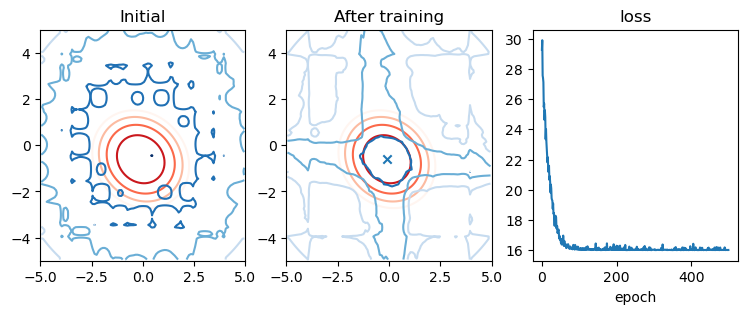

In [6]:
levels = jnp.linspace(-30, 1, 5)

fig, axarr = plt.subplots(1, 3, figsize=(9, 3))
plot_density(axarr[0], true_posterior, cmap='Reds', levels=levels)
plot_density(axarr[0], flow.log_prob, levels=levels)
axarr[0].set_title('Initial')
 
plot_density(axarr[1], true_posterior, cmap='Reds', levels=levels)
plot_density(axarr[1], trained_flow.log_prob, levels=levels)
axarr[1].set_title('After training')
axarr[1].scatter(mean[0], mean[1], marker='x')

axarr[2].plot(losses)
axarr[2].set_title('loss')
axarr[2].set_xlabel('epoch')

plt.show()

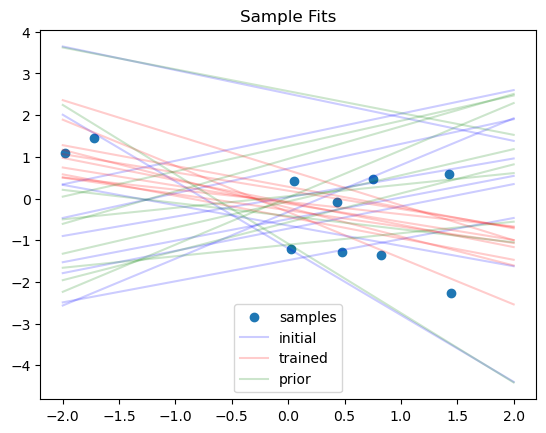

In [7]:
x_inspect = jnp.linspace(2, -2, n)
plots = [
    ('initial', flow, 'b'),
    ('trained', trained_flow, 'r'),
    ('prior', StandardNormal((2,)), 'g'),
]
n_samples = 10

plt.scatter(x, y, label='samples')
for label, _flow, colour in plots:
    w = _flow.sample(flow_key, sample_shape=(n_samples,))
    for ix, (w_0, w_1) in enumerate(w):
        y_inspect = w_0 + w_1 * x_inspect
        plt.plot(x_inspect, y_inspect, alpha=0.2, c=colour, label=label if ix == 0 else None)

plt.title('Sample Fits')
plt.legend()
plt.show()